<a href="https://colab.research.google.com/github/antonpagel/Computational-Optimal-Transport/blob/main/Computational_Optimal_Transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Optimal Transport

## Histograms and Measures

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# @title Plot a Histogram
def plotHistogram(a, title = "", xlabel = "Position", ylabel = "Value") :
    x = np.linspace(0, 1, len(a))
    for i, val in enumerate(a):
        plt.plot([x[i], x[i]], [0, val], color="red")
        plt.scatter(x[i], val, color="red")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

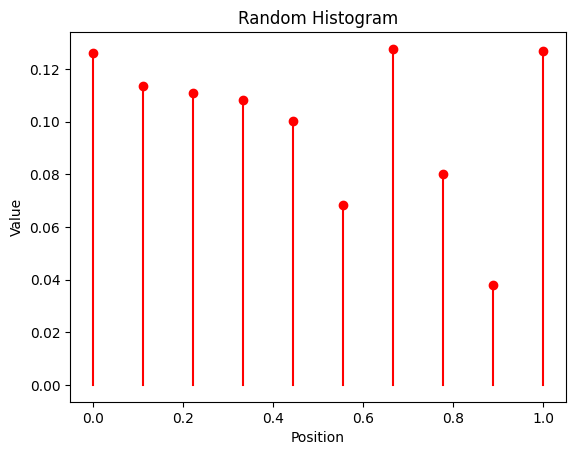

In [3]:
# @title Plot a random Histogram
a = np.random.rand(10)
a = a / np.sum(a)
plotHistogram(a, "Random Histogram")

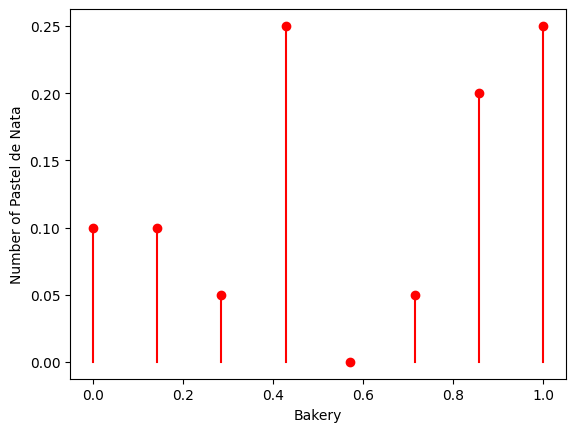

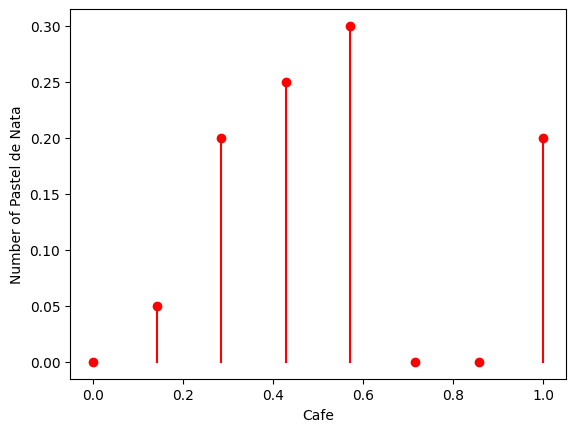

In [4]:
# @title Example Histograms for Bakeries and Cafes

a = np.array([2, 2, 1, 5, 0, 1, 4, 5])
b = np.array([0, 1, 4, 5, 6, 0, 0, 4])
a = a / np.sum(a)
b = b / np.sum(b)

plotHistogram(a, xlabel="Bakery", ylabel="Number of Pastel de Nata")
plotHistogram(b, xlabel="Cafe", ylabel="Number of Pastel de Nata")

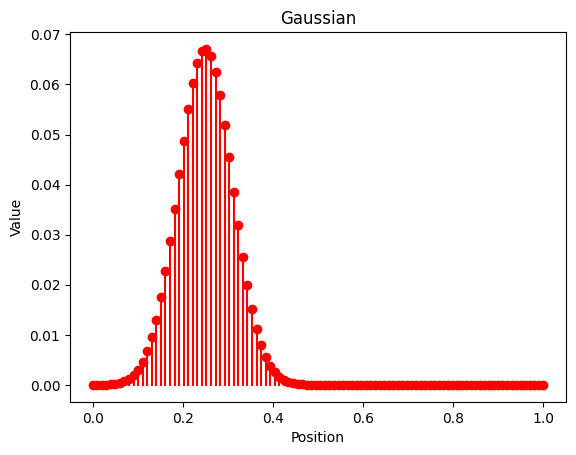

In [5]:
# @title Sampling a Gaussian
def gaussian(x, sigma, mu) :
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((x - mu) / sigma)**2)

def getHistogram(resolution, measure, proportionalMin = 0, **kwargs) :
    a = measure(np.linspace(0, 1, resolution), **kwargs)
    a += np.max(a) * proportionalMin
    return a / np.sum(a)

a = getHistogram(100, gaussian, **{"sigma" : .06, "mu" : .25})
plotHistogram(a, "Gaussian")

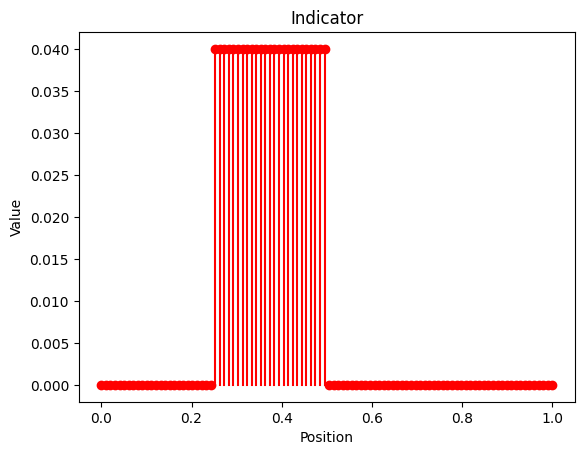

In [6]:
# @title Sampling an indicator function
def indicator(x, lowerBound, upperBound) :
    return [0 if p < lowerBound or upperBound < p else 1 for p in x]

b = getHistogram(100, indicator, **{"lowerBound" : .25, "upperBound" : .5})
plotHistogram(b, "Indicator")

In [7]:
# @title Plot a Matrix
def plotMatrix(M, title = "") :
    plt.imshow(M, extent=[0, 1, 1, 0])
    plt.title(title)
    plt.colorbar();
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

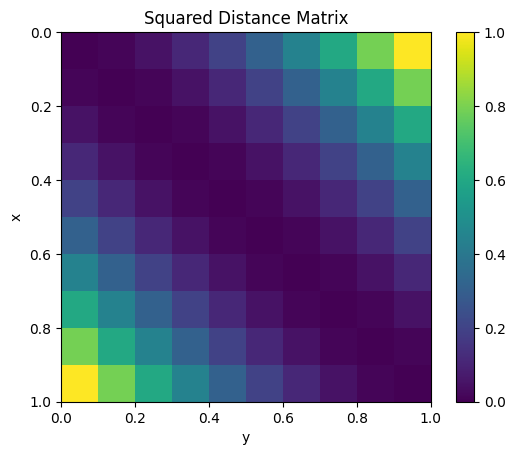

In [8]:
# @title Squared Distance Matrix as Cost Matrix
def getSquaredDistanceMatrix(n, m) :
    C = np.zeros((n, m))
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, m)

    for i in range(n) :
        for j in range(m) :
            C[i, j] = (x[i] - y[j])**2

    return C

C = getSquaredDistanceMatrix(10, 10)
plotMatrix(C, "Squared Distance Matrix")

## Entropic Regularization

## Sinkhorn's Algorithm

In [14]:
# @title Plot Convergence

def plotConvergence(err) :
    plt.plot(np.log10(err[err.astype(bool)]), linewidth = 2)
    plt.title("Convergence")
    plt.xlabel("Step")
    plt.ylabel("Log Error")
    plt.show()

Convergence in 64 steps.


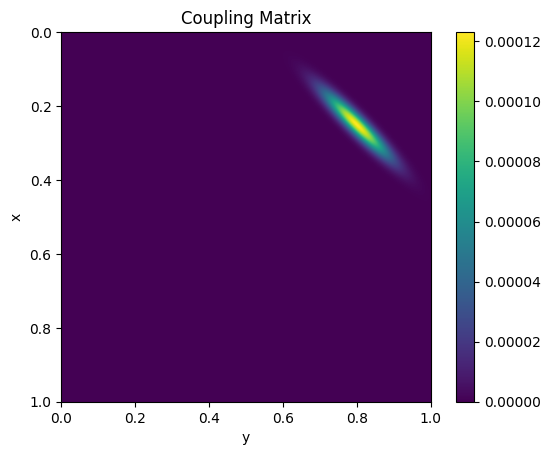

In [15]:
# @title Sinkhorn's Algorithm applied on two Gaussians
# @markdown Change the resolution.
resolution = 1000 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}

def sinkhorn(a, b, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    v = np.ones_like(b)
    u = np.zeros_like(a)

    errB = np.zeros(lMax)

    for l in range(lMax) :
        u = a / np.dot(K, v)
        r = np.dot(np.dot(np.diag(v), np.transpose(K)), u)
        errB[l] = np.linalg.norm((r - b), 1) / len(b)

        v = b / np.dot(np.transpose(K), u)
        if errB[l] < errMax :
            print("Convergence in", l, "steps.")
            break

    return np.dot(np.diag(u), np.dot(K, np.diag(v))), errB

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    plotHistogram(a, "Histogram a")
    plotHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = sinkhorn(a, b, C, eps, 1e-6, 1000)
plotMatrix(P, "Coupling Matrix")

if showConv :
    plotConvergence(err)

In [31]:
# @title Plot Matrix Barycentric Projection

def plotMatrixBarycentricProjection(P, resolution, title = "") :
    t = np.linspace(0, 1, resolution)
    s = np.array([])
    for i in range(0, resolution) :
        s = np.append(s, np.sum(np.dot(P[i, :], t)) / np.sum(P[i, :]))

    plt.imshow(P, extent=[0, 1, 1, 0])
    plt.plot(s, t, "r", linewidth=2)
    plt.title(title)
    plt.colorbar();
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

Convergence in 64 steps.


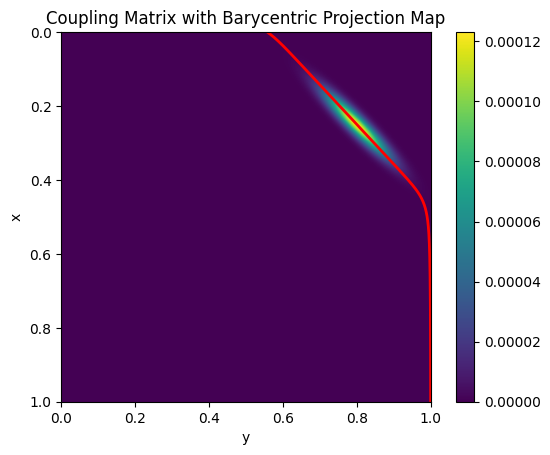

In [33]:
# @title View coupling matrix together with barycentric projection map
# @markdown Change the resolution.
resolution = 1000 # @param ["10","100","1000"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    plotHistogram(a, "Histogram a")
    plotHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = sinkhorn(a, b, C, eps, 1e-6, 1000)

plotMatrixBarycentricProjection(P, resolution, "Coupling Matrix with Barycentric Projection Map")

## Sinkhorn's Algorithm in the Log-Domain
$\DeclareMathOperator{\Min}{Min}$
$$f^{(l+1)} = \Min_\varepsilon^\text{row}(C - 1_n {g^{(l)}}^T) + ɛ \log a \text{ and } g^{(l+1)} = \Min_ɛ^\text{col}(C - f^{(l)} {1_m}^T) + ɛ \log b$$

Convergence in 64 steps.


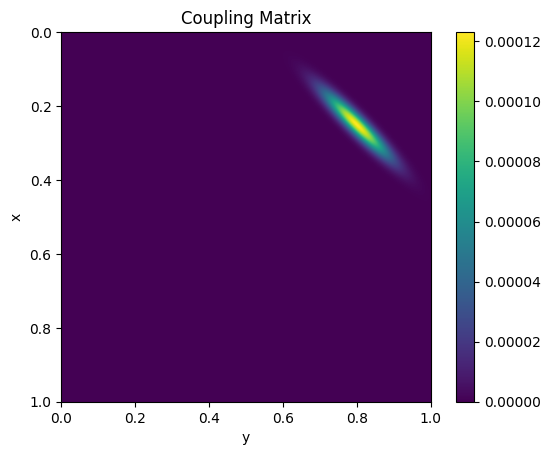

In [34]:
# @title Sinkhorn's Algorithm applied on two Gaussians in the Log-Domain
# @markdown Change the resolution.
resolution = 1000 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}

def softMin(z, eps) :
    return -eps * np.log(np.sum(np.exp(-z / eps)))

def minRow(A, eps) :
    return np.apply_along_axis((lambda z : softMin(z, eps)), 1, A)

def minCol(A, eps) :
    return np.apply_along_axis((lambda z : softMin(z, eps)), 0, A)

def S(C, f, g) :
    return C - np.outer(f, np.ones_like(f)) - np.outer(np.ones_like(g), g)

def logSinkhorn(a, b, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    f = np.zeros_like(a)
    g = np.zeros_like(b)

    errA = np.zeros(lMax)

    for l in range(lMax) :
        f = minRow(S(C, f, g), eps) + f + eps * np.log(a)
        g = minCol(S(C, f, g), eps) + g + eps * np.log(b)

        P = np.exp((np.outer(f, np.ones_like(f)) - C + np.outer(np.ones_like(g), g)) / eps)

        s = np.dot(P, np.ones_like(a))
        r = np.dot(np.transpose(P), np.ones_like(b))
        errA[l] = np.linalg.norm((s - a), 1) / len(a)
        if errA[l] < errMax :
            print("Convergence in", l, "steps.")
            break

    return P, errA

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    plotHistogram(a, "Histogram a")
    plotHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = logSinkhorn(a, b, C, eps, 1e-6, 1000)
plotMatrix(P, "Coupling Matrix")

if showConv :
    plotConvergence(err)

## Optimal Transport Barycenters
$\forall s \in \{1, \dots S\}: v_s^{(l+1)} = \frac{b_s}{K^T u_s^{(l)}}$ and $\forall s \in \{1, \dots, S\}: u_s^{(l+1)} = \frac{a^{(l)}}{K v_s^{(l+1)}}$ where $a^{(l)} = \prod_{s=1}^S ( u_s^{(l)} \odot (K v_s^{(l+1)}))$

### One Dimensional

Convergence in 261 steps.


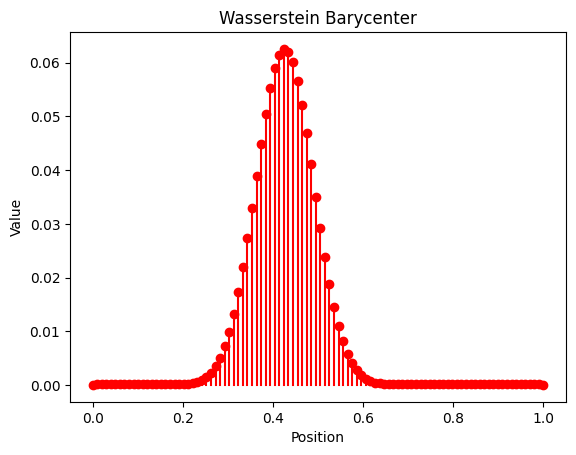

In [35]:
from binascii import b2a_base64
# @title Wasserstein Barycenter of two Gaussians
# @markdown Change the resolution.
resolution = 100 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}
# @markdown Select the weights.
lambda2 = 0.32 # @param {"type":"slider","min":0,"max":1,"step":0.01}

def barycenter(b1, b2, res, lambd, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    S = 2

    B = np.zeros([res, S])
    B[:, 0] = b1
    B[:, 1] = b2

    U = np.ones([res, S])
    V = np.zeros([res, S])

    err = np.zeros([lMax, S])

    a = np.ones(res)

    for l in range(lMax) :
        for s in range(S) :
            V[:, s] = B[:, s] / np.dot(np.transpose(K), U[:, s])

        a = np.ones(res)
        for s in range(S) :
            a = a * (U[:, s] * np.dot(K, V[:, s]))**lambd[s]

        for s in range(S) :
            U[:, s] = a / np.dot(K, V[:, s])
            r = np.dot(np.dot(np.diag(V[:, s]), np.transpose(K)), U[:, s])
            err[l, s] = np.linalg.norm((r - B[:, s]), 1) / res

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    P = np.zeros([res, res, S])

    for s in range(S) :
        P[:, :, s] = np.dot(np.diag(U[:, s]), np.dot(K, np.diag(V[:, s])))

    return P, a, err

b1 = getHistogram(resolution, gaussian, .001, **{"sigma" : .06, "mu" : .25})
b2 = getHistogram(resolution, gaussian, .001, **{"sigma" : .06, "mu" : .8})

C = getSquaredDistanceMatrix(resolution, resolution)

P, a, err = barycenter(b1, b2, resolution, np.array([1-lambda2, lambda2]), C, eps, 1e-8, 1000)

if showHist :
    plotHistogram(b1, "First Histogram")
    plotHistogram(b2, "Second Histogram")

plotHistogram(a, "Wasserstein Barycenter")

if showConv :
    plotConvergence(err[:, 0])
    plotConvergence(err[:, 1])

Convergence in 121 steps.


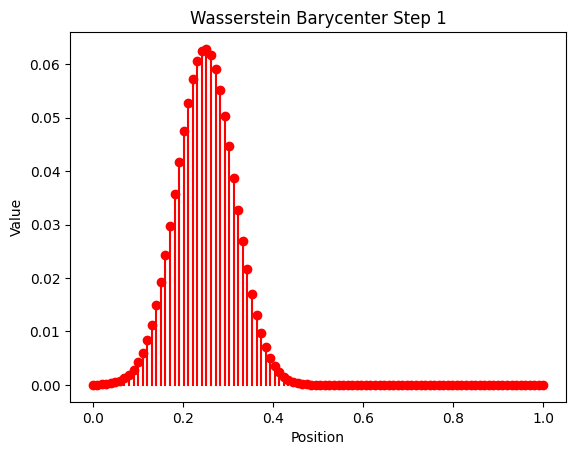

Convergence in 119 steps.


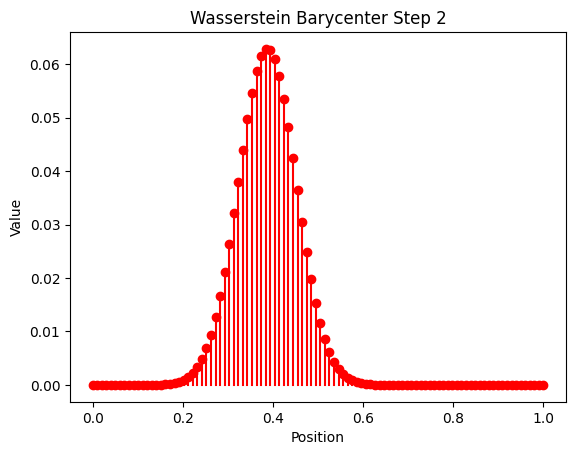

Convergence in 116 steps.


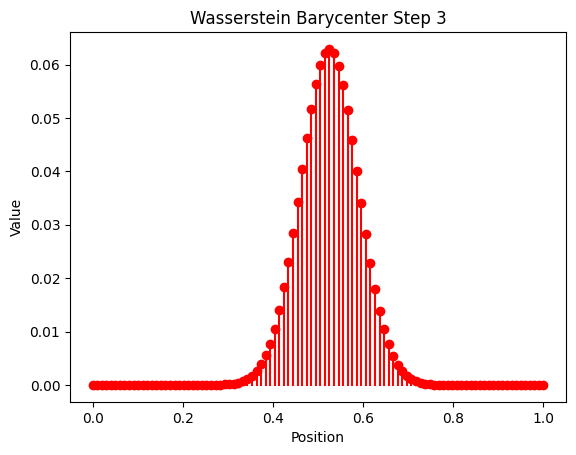

Convergence in 119 steps.


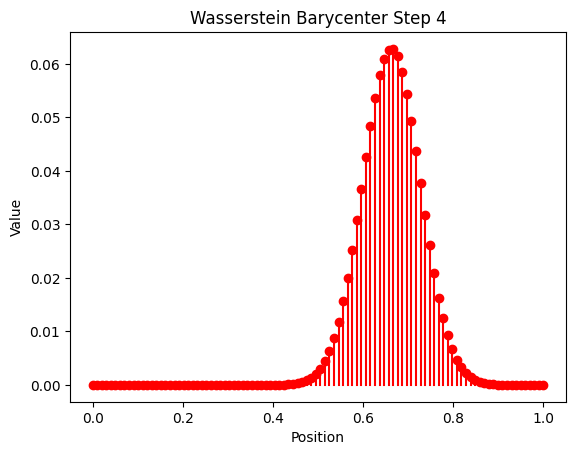

Convergence in 121 steps.


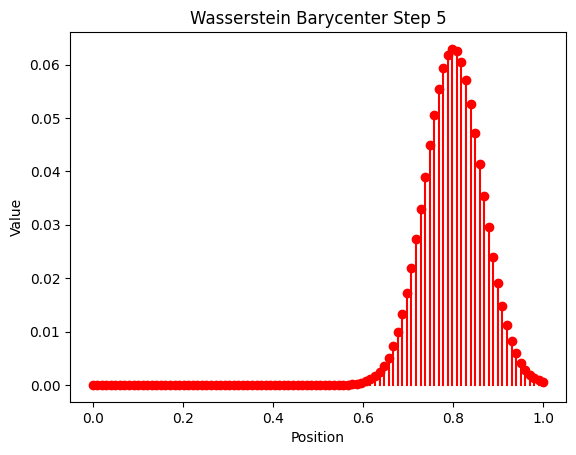

In [38]:
# @title Wasserstein Barycenter of two Gaussians in $n$ Steps
# @markdown Change the resolution.
resolution = 100 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 5 # @param {"type":"integer"}

b1 = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b2 = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

C = getSquaredDistanceMatrix(resolution, resolution)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter(b1, b2, resolution, lambd, C, eps, 1e-8, 1000)
    plotHistogram(a, "Wasserstein Barycenter Step " + str(i+1))

### Two Dimensional

In [ ]:
# @title Upload Files

from google.colab import files
from matplotlib import pyplot as plt
import numpy as np
import cv2

def plotImage(img, title = "", axis = True) :
    plt.imshow(img)
    plt.title(title)
    if not axis :
        plt.axis("off")
    plt.show()

uploaded = files.upload()

for fn in uploaded.keys() :
    plotImage(cv2.imread(fn, cv2.IMREAD_GRAYSCALE), "Uploaded file {name} with length {length} bytes".format(name=fn, length=len(uploaded[fn])))

Convergence in 1875 steps.


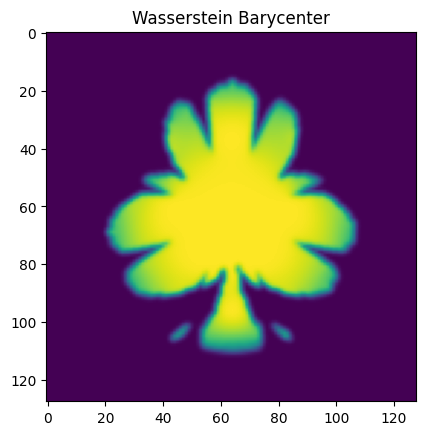

In [ ]:
# @title Two Dimensional Wasserstein Barycenter
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-4 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}
# @markdown Select the weights.
lambda2 = 0.21 # @param {"type":"slider","min":0,"max":1,"step":0.01}

def getKernelAsFunc(X, Y, eps) :
    K1 = np.exp(-(X-Y)**2/eps)
    K = lambda x: np.dot(np.dot(K1,x),K1)
    return K

def getImageAsHistogram(fn, res, min) :
    img = cv2.resize(cv2.imread(fn, cv2.IMREAD_GRAYSCALE), (res, res), interpolation=cv2.INTER_NEAREST)
    img = (img + .01) / np.sum(img + .01)
    return img

def barycenter2d(b1, b2, res, lambd, eps, errMax, lMax) :
    [X, Y] = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    K = getKernelAsFunc(X, Y, eps)
    S = 2

    B = np.zeros([res, res, S])
    B[:, :, 0] = b1
    B[:, :, 1] = b2

    err = np.zeros([lMax, S])

    U = np.ones([res, res, S])
    V = np.zeros([res, res, S])

    a = np.ones([res, res])

    for l in range(lMax) :
        for s in range(S) :
            V[:, :, s] = B[:, :, s] / K(U[:, :, s])

        a = np.zeros([res, res])
        for s in range(S) :
            a = a + np.log(np.maximum(1e-19*np.ones([res, res]), U[:, :, s]*K(V[:, :, s]))) * lambd[s]

        a = np.exp(a)

        for s in range(S) :
            U[:, :, s] = a / K(V[:, :, s])
            r = V[:, :, s] * K(U[:, :, s])
            err[l, s] = np.linalg.norm(r - B[:, :, s], 1) / (res**2)

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    P = np.zeros([res, res, res, res, S])

    for s in range(S) :
        P[:, :, :, :, s] = np.dot(np.diag(U[:, :, s]), K(V[:, :, s]))

    return P, a, err

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)

if showHist :
    plotImage(b1, "Clover")
    plotImage(b2, "Star")

P, a, err = barycenter2d(b1, b2, resolution, np.array([1-lambda2, lambda2]), eps, 1e-9, 3000)

plotImage(a, "Wasserstein Barycenter")

if showConv :
    plotConvergence(err[:, 0])
    plotConvergence(err[:, 1])

Convergence in 206 steps.


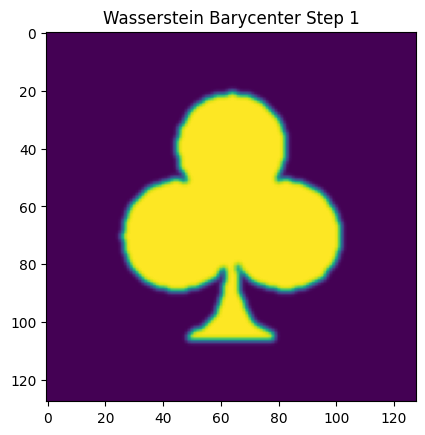

Convergence in 160 steps.


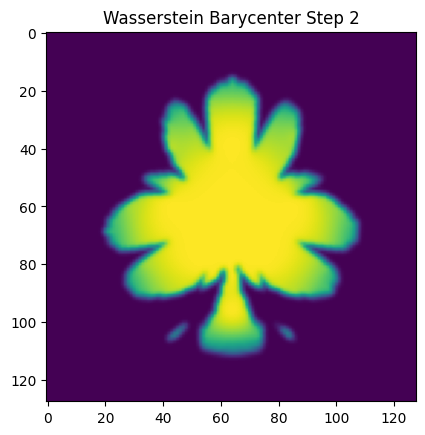

Convergence in 89 steps.


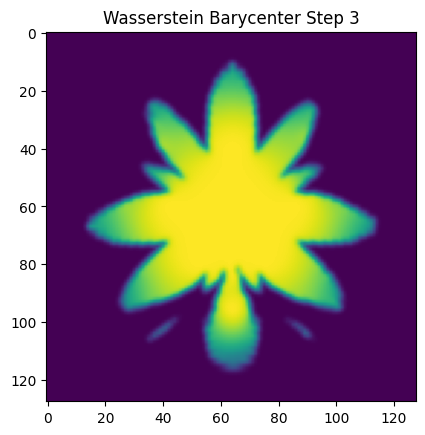

Convergence in 134 steps.


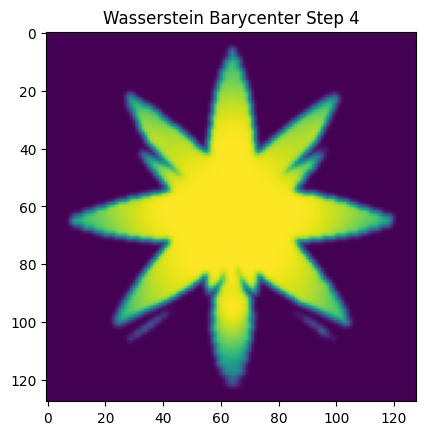

Convergence in 176 steps.


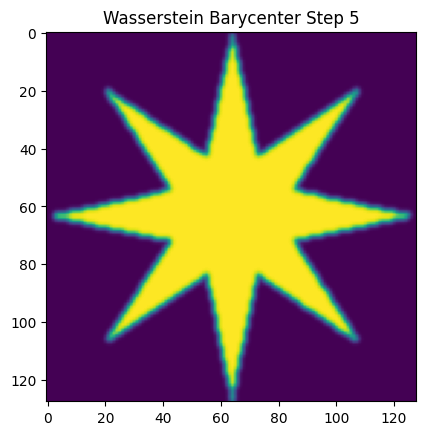

In [ ]:
# @title Two Dimensional Wasserstein Barycenter in $n$ Steps
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-4 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 5 # @param {"type":"integer"}

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter2d(b1, b2, resolution, lambd, eps, 1e-7, 3000)
    plotImage(a, "Wasserstein Barycenter Step " + str(i+1))

Convergence in 193 steps.


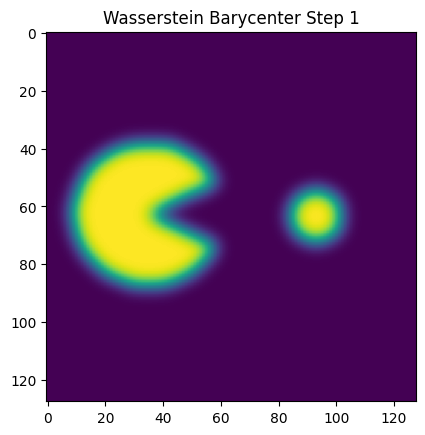

Convergence in 181 steps.


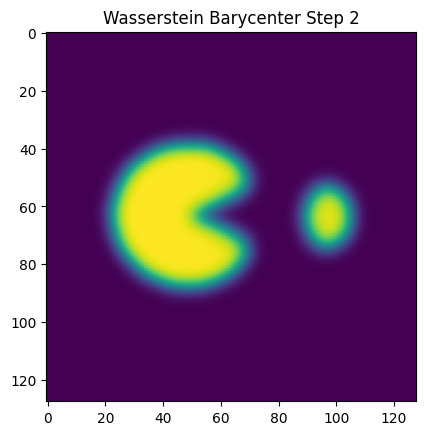

Convergence in 163 steps.


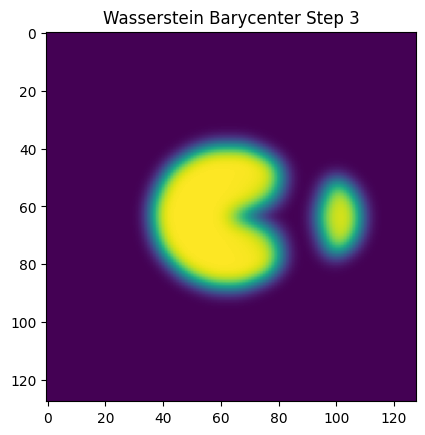

Convergence in 160 steps.


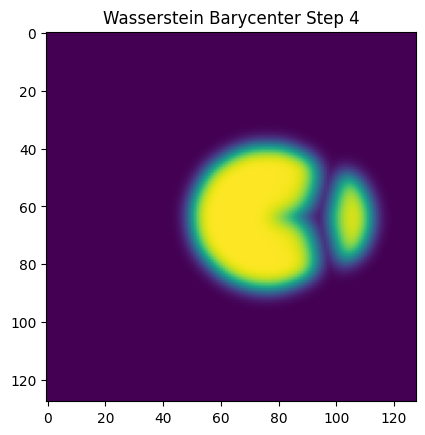

Convergence in 176 steps.


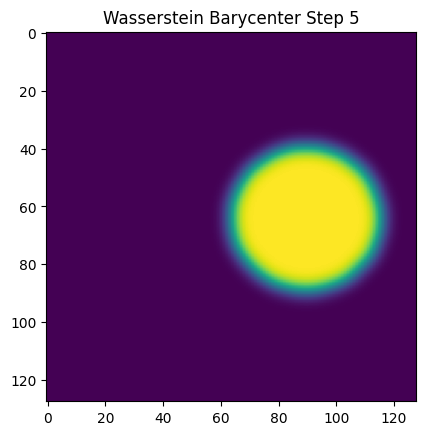

In [ ]:
# @title Pacman
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 5 # @param {"type":"integer"}

b1 = getImageAsHistogram("pacman1.bmp", resolution, .01)
b2 = getImageAsHistogram("pacman2.bmp", resolution, .01)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter2d(b1, b2, resolution, lambd, eps, 1e-7, 3000)
    plotImage(a, "Wasserstein Barycenter Step " + str(i+1))

Convergence in 474 steps.


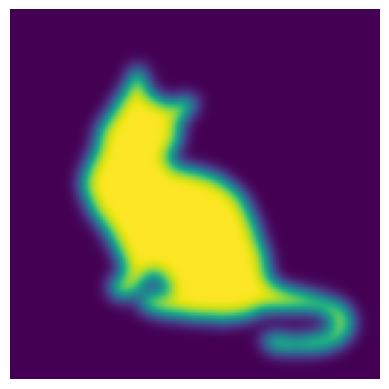

Convergence in 449 steps.


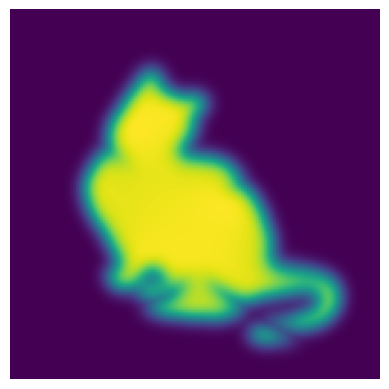

Convergence in 452 steps.


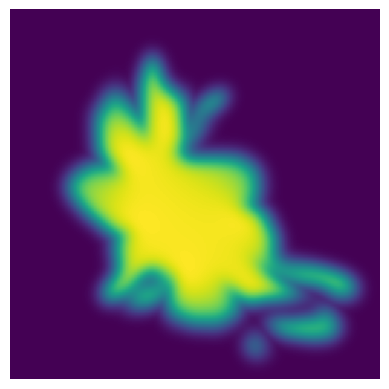

Convergence in 416 steps.


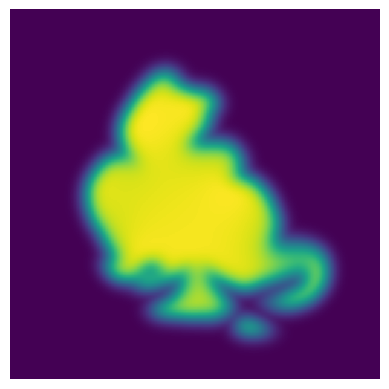

Convergence in 418 steps.


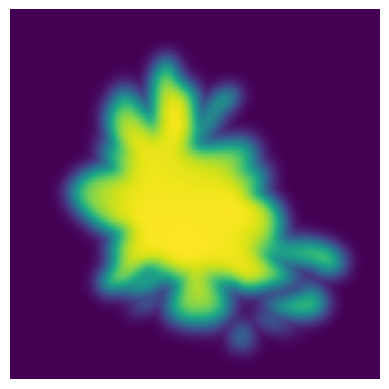

Convergence in 420 steps.


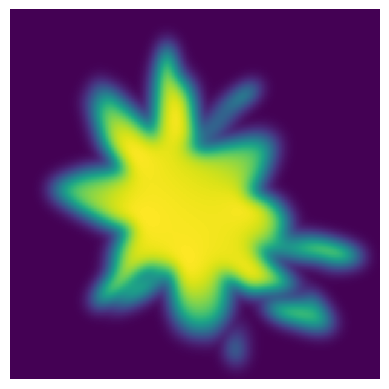

Convergence in 396 steps.


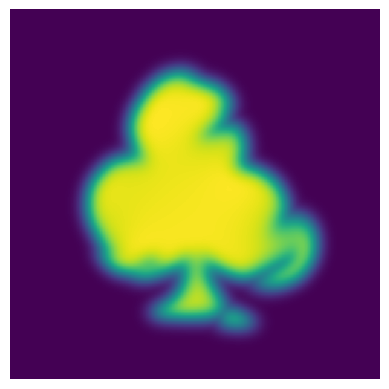

Convergence in 403 steps.


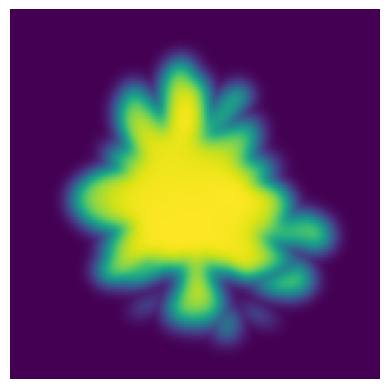

Convergence in 411 steps.


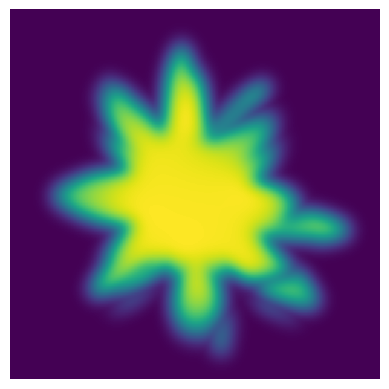

Convergence in 420 steps.


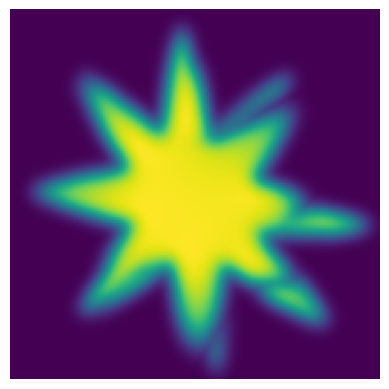

Convergence in 418 steps.


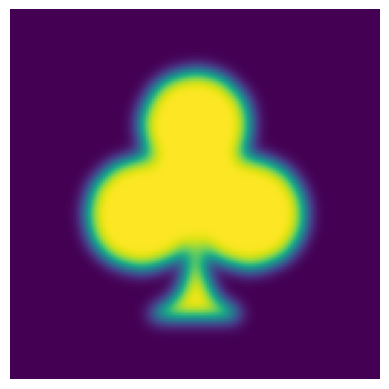

Convergence in 423 steps.


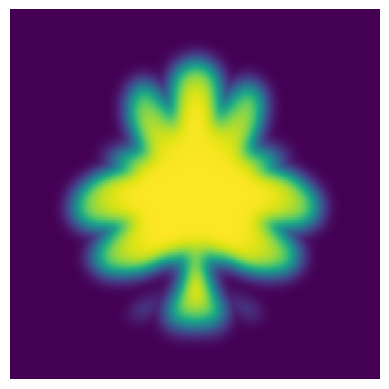

Convergence in 429 steps.


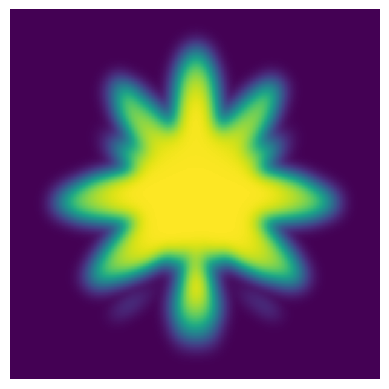

Convergence in 437 steps.


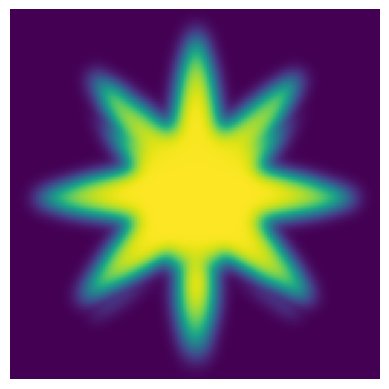

Convergence in 445 steps.


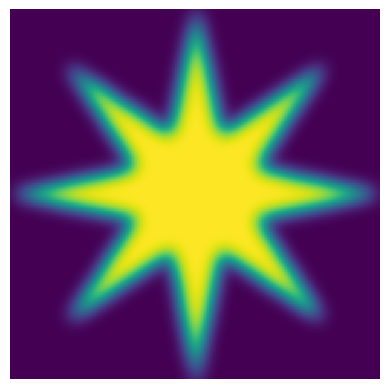

In [ ]:
# @title Triangle
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}

def barycenter2d3hist(b1, b2, b3, res, lambd, eps, errMax, lMax) :
    [X, Y] = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    K = getKernelAsFunc(X, Y, eps)
    S = 3

    B = np.zeros([res, res, S])
    B[:, :, 0] = b1
    B[:, :, 1] = b2
    B[:, :, 2] = b3

    err = np.zeros([lMax, S])

    U = np.ones([res, res, S])
    V = np.zeros([res, res, S])

    a = np.ones([res, res])

    for l in range(lMax) :
        for s in range(S) :
            V[:, :, s] = B[:, :, s] / K(U[:, :, s])

        a = np.zeros([res, res])
        for s in range(S) :
            a = a + np.log(np.maximum(1e-19*np.ones([res, res]), U[:, :, s]*K(V[:, :, s]))) * lambd[s]

        a = np.exp(a)

        for s in range(S) :
            U[:, :, s] = a / K(V[:, :, s])
            r = V[:, :, s] * K(U[:, :, s])
            err[l, s] = np.linalg.norm(r - B[:, :, s], 1) / (res**2)

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    return a, err

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)
b3 = getImageAsHistogram("cat.bmp", resolution, .01)

Lambd = np.zeros([3, 15])
Lambd[:, 0] = np.array([0, 0, 1])
Lambd[:, 1] = np.array([1, 0, 3])
Lambd[:, 2] = np.array([0, 1, 3])
Lambd[:, 3] = np.array([1, 0, 1])
Lambd[:, 4] = np.array([1, 1, 2])
Lambd[:, 5] = np.array([0, 1, 1])
Lambd[:, 6] = np.array([3, 0, 1])
Lambd[:, 7] = np.array([2, 1, 1])
Lambd[:, 8] = np.array([1, 2, 1])
Lambd[:, 9] = np.array([0, 3, 1])
Lambd[:, 10] = np.array([1, 0, 0])
Lambd[:, 11] = np.array([3, 1, 0])
Lambd[:, 12] = np.array([1, 1, 0])
Lambd[:, 13] = np.array([1, 3, 0])
Lambd[:, 14] = np.array([0, 1, 0])

for i in range(Lambd.shape[1]) :
    Lambd[:, i] = Lambd[:, i] / np.sum(Lambd[:, i])
    a, err = barycenter2d3hist(b1, b2, b3, resolution, Lambd[:, i], eps, 1e-9, 3000)
    plotImage(a, axis = False)